In [1]:
import sys
import os
import h5py
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss


101088

In [2]:
# DEFINE STIMULUS
random_seed = 10
np.random.seed(random_seed)

sr = 32000

def get_y(f0=200):
    fs = sr
    dur = 0.150
    y = util_stimuli.complex_tone(
        f0,
        fs,
        dur=dur,
        harmonic_numbers=np.arange(1, 600),
        frequencies=None,
        amplitudes=None,
        phase_mode='sine',
        offset_start=True,
        strict_nyquist=False)
    noise = util_stimuli.TENoise(fs, dur, dBSPL_per_ERB=70.0)
    snr = np.inf
    dBSPL = 60
    y = util_stimuli.combine_signal_and_noise(y, noise, snr, mean_subtract=True)
    y = util_stimuli.set_dBSPL(y, dBSPL)
    return y

y = np.stack([get_y(f0=150), get_y(f0=250)], axis=1)
print(y.shape)

ipd.display(ipd.Audio(y.T, rate=sr))
        

(4800, 2)


In [13]:
# RUN `nervegram` model
kwargs_nervegram = {
    'nervegram_dur': 0.050,
    'nervegram_fs': 20e3,
    'buffer_start_dur': 0.070,
    'buffer_end_dur': 0.010,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 1,
    'pin_dBSPL': 70,
    'species': 2,
    'bandwidth_scale_factor': 1,
    'cf_list': None,
    'num_cf': 100,
    'min_cf': 125.0,
    'max_cf': 8e3,
    'synapseMode': 0,
    'max_spikes_per_train': 500,
    'num_spike_trains': 20,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3000,
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 1,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': True,
    'return_meanrates': True,
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': False,
    'nervegram_spike_tensor_fs': 20e3,
    'squeeze_channel_dim': True
}

importlib.reload(bez2018model)

for _ in range(1):
    np.random.seed(random_seed)
    t = time.time()
    out_dict = bez2018model.nervegram(y[:, 0], sr, **kwargs_nervegram)
    print('TIME:', time.time() - t)
    print('MEMORY:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
    if 'nervegram_spike_tensor_dense' in out_dict:
        print(out_dict['nervegram_spike_tensor_dense'].sum())

print('')
for k in sorted(out_dict.keys()):
    print(k, np.array(out_dict[k]).dtype, np.array(out_dict[k]).shape)


TIME: 7.73530125617981
MEMORY: 139784

IhcLowPass_cutoff int64 ()
IhcLowPass_order int64 ()
bandwidth_scale_factor float32 (100,)
buffer_end_dur float64 ()
buffer_start_dur float64 ()
cf_list float32 (100,)
cihc float64 (100,)
cohc float64 (100,)
implnt int64 ()
max_spikes_per_train int64 ()
nervegram_dur float64 ()
nervegram_fs float64 ()
nervegram_meanrates float32 (100, 1000)
nervegram_spike_tensor_fs float64 ()
nervegram_vihcs float32 (100, 1000)
noiseType int64 ()
num_spike_trains int64 ()
pin float32 (5000,)
pin_dBSPL int64 ()
pin_dBSPL_flag int64 ()
pin_fs float64 ()
signal float32 (1600,)
signal_fs int64 ()
species int64 ()
spont float64 ()
synapseMode int64 ()
tabs float64 ()
trel float64 ()


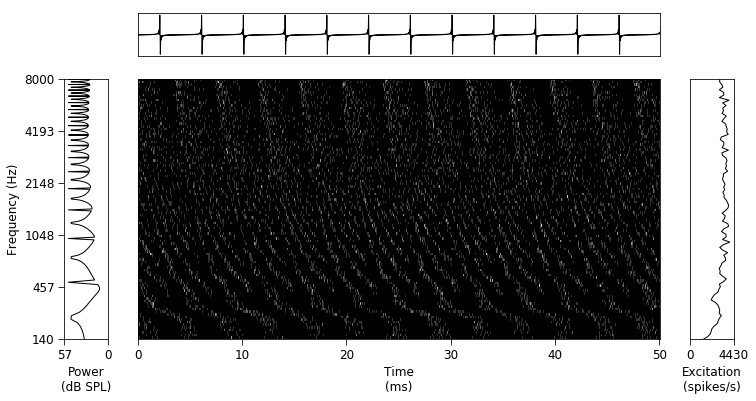

In [7]:
figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 12, 1],
    'height_ratios': [1, 6],
}

IDX_CHANNEL = 1
waveform = out_dict['pin'][:, IDX_CHANNEL]
sr_waveform = out_dict['pin_fs']
nervegram = out_dict['nervegram_spike_tensor_dense'][:, :, :, IDX_CHANNEL].sum(axis=0)
sr_nervegram = out_dict['nervegram_spike_tensor_fs']
# nervegram = out_dict['nervegram_meanrates'][:, :, IDX_CHANNEL]
# sr_nervegram = out_dict['nervegram_fs']


if True:
    fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
    util_figures.make_stimulus_summary_plot(ax_arr,
                                            ax_idx_waveform=1,
                                            ax_idx_spectrum=3,
                                            ax_idx_nervegram=4,
                                            ax_idx_excitation=5,
#                                             tmin=0.3,
#                                             tmax=0.4,
                                            waveform=waveform,
                                            nervegram=nervegram,
                                            sr_waveform=sr_waveform,
                                            sr_nervegram=sr_nervegram,
                                            cfs=out_dict['cf_list'])
    plt.tight_layout()
    plt.show()

#     fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=False)


In [ ]:
figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = out_dict['pin']
sr_waveform = out_dict['pin_fs']
nervegram = out_dict['nervegram_meanrates']
sr_nervegram = out_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()
    
# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=False)


In [ ]:
kwargs_nervegram :  {
    'nervegram_dur': None,
    'nervegram_fs': 10e3,
    'buffer_start_dur': 0.0,
    'buffer_end_dur': 0.0,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 50,
    'min_cf': 125.0,
    'max_cf': 8e3,
    'max_spikes_per_train': -1,
    'num_spike_trains': 40,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3e3,
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 1,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': True,
    'return_meanrates': True,
    'return_spike_times': True,
    'return_spike_tensor': True
}

In [ ]:
# fxx, pxx = util_stimuli.power_spectrum(y, sr)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
# ax.plot(fxx, pxx, color='k', lw=1)

# ax.set_xlim([0, 8050])
# ax.set_ylim([0, 30])
# ax.set_xlabel('Frequency (Hz)', fontsize=16)
# ax.set_ylabel('dB/Hz SPL', fontsize=16)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# plt.show()


figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
nervegram = out_dict['meanrates']
sr_nervegram = out_dict['meanrates_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=None,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()


In [ ]:
pin_fs = out_dict['pin_fs']
pin = out_dict['pin']
mr_fs = out_dict['meanrates_fs']
mr = out_dict['meanrates']
freq = out_dict['cf_list']
pin_fs = out_dict['pin_fs']

fidx = 0
print('cf=', freq[fidx])

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

fxx, pxx = util_stimuli.power_spectrum(mr_trace, mr_fs)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
ax[0].plot(mr_time, mr_trace, color='k')
ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, IHC_cutoff={:.2f}'.format(freq[fidx], IHC_cutoff))


ax[1].axvline(IHC_cutoff, color='r', label='IHC_cutoff')
ax[1].axvline(5000, color='b', ls='--', lw=0.5, label='old Nyquist')
ax[1].plot(fxx, pxx, color='k')
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

signal = np.random.randn(1000)
noise = np.random.rand(1000)

snr = 60

signal = signal - np.mean(signal)
noise = noise - np.mean(noise)

signal = 0.2 * signal


In [ ]:
# Debugging work for custom spike-sampling from meanrates

# rate = out_dict['nervegram_meanrates']
# rate_sr = out_dict['nervegram_fs']
# nervegram_binomial = np.zeros_like(out_dict['nervegram_psth'])
# for itrANF in range(nervegram_binomial.shape[-1]):
#     spikes = np.sign((rate/rate_sr) - np.random.rand(*rate.shape))
#     spikes[spikes < 0] = 0
#     nervegram_binomial[:, :, :, itrANF] = spikes

rate = np.zeros_like(out_dict['nervegram_psth'])
for itrANF in range(rate.shape[-1]):
    rate[:, :, :, itrANF] = out_dict['nervegram_meanrates'].copy()
print(rate.shape)

rate_sr = out_dict['nervegram_fs']
nervegram_binomial = np.zeros_like(out_dict['nervegram_psth'])
dur_refract = int(0.004 * rate_sr)
print(dur_refract)
for t in range(rate.shape[1]):
    t_prob = rate[:, t:t+1, :, :] / rate_sr
    t_spks = np.sign(t_prob - np.random.rand(*t_prob.shape))
    t_spks[t_spks < 0] = 0
#     if t < rate.shape[1] - 1:
#         t_end = min(t + 1 + dur_refract, rate.shape[1])
#         rate[:, t+1:t_end, :, :] *= t_spks == 0
    for t_refract in range(t + 1, t + 1 + dur_refract):
        if t_refract >= rate.shape[1]:
            break
        rate[:, t_refract:t_refract+1, :, :] *= t_spks == 0
    nervegram_binomial[:, t:t+1, :, :] = t_spks

nervegram_binomial.shape


In [ ]:
figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
nervegram = np.sum(out_dict['nervegram_psth'][:, :, :, 0:200], axis=-1)
# nervegram = np.sum(nervegram_binomial[:, :, :, 0:200], axis=-1)
# nervegram = out_dict['nervegram_meanrates']
sr_nervegram = out_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()




nervegram = np.sum(nervegram_binomial[:, :, :, 0:200], axis=-1)

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()


In [ ]:
spike_counts_1 = []
spike_counts_2 = []

nervegram_1 = out_dict['nervegram_psth']
nervegram_2 = nervegram_binomial

print(nervegram_1.shape, nervegram_2.shape)
assert nervegram_1.shape == nervegram_2.shape
for _ in range(5000):
    idx_cf = np.random.randint(nervegram_1.shape[0])
    idx_dur = np.random.randint(nervegram_1.shape[1])
    idx_start = np.random.randint(nervegram_1.shape[1] - idx_dur)
    idx_anf = np.random.randint(nervegram_1.shape[3])
    
    spike_counts_1.append( np.sum(nervegram_1[idx_cf, idx_start:idx_start+idx_dur, 0, :]) )
    spike_counts_2.append( np.sum(nervegram_2[idx_cf, idx_start:idx_start+idx_dur, 0, :]) )

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(spike_counts_1, spike_counts_2, 'k.', ms=0.5)
ax.plot(spike_counts_1, spike_counts_1, 'r--')
ax.set_xlabel('bez2018model spike counts in random segments')
ax.set_ylabel('binomial spike counts in random segments')

plt.show()


In [ ]:
cf_idx = 48
num_anfs = 20

bez2018model_spikes = np.sum(out_dict['nervegram_psth'][cf_idx:cf_idx+1, :, :, -num_anfs:], axis=(0, 2, 3))
bez2018model_label = 'bez2018model ({} spikes)'.format(int(bez2018model_spikes.sum()))

binomial_spikes = np.sum(nervegram_binomial[cf_idx:cf_idx+1, :, :, -num_anfs:], axis=(0, 2, 3))
binomial_label = 'binomial ({} spikes)'.format(int(binomial_spikes.sum()))

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(bez2018model_spikes + np.max(binomial_spikes) * 1.1, label=bez2018model_label)
ax.plot(binomial_spikes, label=binomial_label)
ax.legend()
plt.show()


In [ ]:
import cython_bez2018
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import time

cf = 250.0
pin_fs = 100e3
dur = 0.05
t = np.arange(0, dur, 1/pin_fs)
pin = 1e3*np.sin(2*np.pi*250.0*t)

nrep = 1

t0 = time.time()
for _ in range(nrep):
    vihc = cython_bez2018.run_ihc(pin,
                                  pin_fs,
                                  cf,
                                  species=2,
                                  bandwidth_scale_factor=1,
                                  cohc=1,
                                  cihc=1,
                                  IhcLowPass_cutoff=3000,
                                  IhcLowPass_order=7)
t1 = time.time()

for _ in range(nrep):
    np.random.seed(1)
    out_dict_tmp = cython_bez2018.run_anf(vihc,
                                          pin_fs,
                                          cf,
                                          num_spike_trains=16000,
                                          max_spikes_per_train=500)
t2 = time.time()

for _ in range(nrep):
    np.random.seed(1)
    out_dict = cython_bez2018.run_synapse(vihc,
                                          pin_fs,
                                          cf)
t3 = time.time()

print('time for run_ihc', (t1-t0)/nrep)
print('time for tmp_test', (t2-t1)/nrep)
print('time for run_synapse', (t3-t2)/nrep)

# fig, ax = plt.subplots(figsize=(10, 2))
# ax.plot(t, pin)
# ax.plot(sptime, np.zeros_like(sptime), '.')
# plt.show()
# fig, ax = plt.subplots(figsize=(10, 2))
# ax.plot(t, vihc)
# ax.plot(sptime, np.zeros_like(sptime), '.')
# plt.show()

x0 = out_dict_tmp['meanrate']
x1 = out_dict['meanrate']

for k in out_dict_tmp.keys():
    print(k, out_dict_tmp[k].shape, out_dict_tmp[k].max())

print(np.max(np.abs(x1-x0)))


In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(t, x0)
ax.plot(t, x1)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

for n in range(out_dict_tmp['spike_times'].shape[0]):
    X = out_dict_tmp['spike_times'][n]
    X = X[X>0]
    ax.plot(X, np.ones_like(X) * n, '.')
plt.show()


t_bins = np.arange(0, dur, 1/10000)

hist, bin_edges = np.histogram(out_dict_tmp['spike_times'], t_bins)
fig, ax = plt.subplots(figsize=(18, 2))
ax.plot(t_bins[1:len(hist)], hist[1:])
plt.show()


In [ ]:
# X = out_dict_tmp['spike_times']
X = out_dict['nervegram_spike_times']
print(X.shape)

# X = X.reshape([-1, 40, 50, 500]).astype(np.float32)
X = np.expand_dims(X, axis=0)
shape_X = [None] + list(X.shape)[1:]
print(X.shape, X.dtype)
print(np.sum(X>0))
shape_X


In [ ]:
import sys
import os
import h5py
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import importlib

import bez2018model_run_hdf5_dataset
importlib.reload(bez2018model_run_hdf5_dataset)

import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

fs = 32000
f0 = 240
dur = 0.150
y = util_stimuli.complex_tone(f0,
                              fs,
                              dur=dur,
                              harmonic_numbers=np.arange(1, 600),
                              frequencies=None,
                              amplitudes=None,
                              phase_mode='sine',
                              offset_start=True,
                              strict_nyquist=False)
noise = util_stimuli.TENoise(fs, dur, dBSPL_per_ERB=70.0)
snr = np.inf
dBSPL = 60
y = util_stimuli.combine_signal_and_noise(y, noise, snr, mean_subtract=True)
y = util_stimuli.set_dBSPL(y, dBSPL)

kwargs_nervegram = {
    'nervegram_dur': 0.05,
    'nervegram_fs': 10e3,
    'buffer_start_dur': 0.070,
    'buffer_end_dur': 0.010,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': [1],
    'cf_list': None,
    'num_cf': 50,
    'min_cf': 125.0,
    'max_cf': 8e3,
    'synapseMode': 0,
    'max_spikes_per_train': 1000,
    'num_spike_trains': 20,
    'cohc': [1.0],
    'cihc': [1.0]*25 + [0.0]*25,
    'IhcLowPass_cutoff': 3000,
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 1,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': True,
    'return_meanrates': True,
    'return_spike_times': True,
    'return_spike_tensor_sparse': True,
    'return_spike_tensor_dense': True,
    'nervegram_spike_tensor_fs': 10e3
}

t0 = time.time()
m0 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
out_dict = bez2018model.nervegram(y, fs, **kwargs_nervegram)
m1 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
t1 = time.time()
print('MEMORY:', m1-m0, 'TIME:', t1-t0)

for k in sorted(out_dict.keys()):
    print(k, np.array(out_dict[k]).dtype, np.array(out_dict[k]).shape, sys.getsizeof(out_dict[k]))

data_dict = out_dict
config_key_pair_list = bez2018model_run_hdf5_dataset.get_default_config_key_pair_list(data_dict)
data_key_pair_list = bez2018model_run_hdf5_dataset.get_default_data_key_pair_list(data_dict)

# N = 500
# fn = 'tmp.hdf5'
# bez2018model_run_hdf5_dataset.initialize_hdf5_file(
#     fn,
#     N,
#     data_dict,
#     file_mode='w',
#     data_key_pair_list=data_key_pair_list,
#     config_key_pair_list=config_key_pair_list,
#     dtype=np.float32,
#     cast_data=False,
#     cast_config=False,
#     compression=None,
#     compression_opts=None)

# print('\n\n\n=== HDF5 OUTPUT FILE STRUCTURE ===')
# with h5py.File(fn, 'r+') as f:
#     for k in util_misc.get_hdf5_dataset_key_list(f):
#         print(k, f[k])

#     for itr0 in range(5):
#         for itr1 in range(f['nervegram_spike_tensor_dense_shape'][0].shape[0]):
#             k = 'nervegram_spike_tensor_sparse{}'.format(itr1)
#             f[k][itr0] = data_dict[k].copy()
#             print(itr0, k, f[k], f[k][itr0].shape, f[k][itr0].dtype)


In [ ]:
with h5py.File(fn, 'r+') as f:
    print(k, f[k][4].shape, f[k][0].dtype)


In [ ]:
import time

nervegram_spike_times = out_dict['nervegram_spike_times']
nervegram_spike_tensor_fs = 100e3
nervegram_spike_indices = (nervegram_spike_times * nervegram_spike_tensor_fs).astype(int)

t0 = time.time()
list_idx012 = []
for itr0 in range(nervegram_spike_indices.shape[0]):
    for itr1 in range(nervegram_spike_indices.shape[1]):
        for itr2 in np.trim_zeros(nervegram_spike_indices[itr0, itr1], trim='b'):
            list_idx012.append([itr0, itr1, itr2])
        
list_idx012 = np.array(list_idx012)
list_idx012 = list_idx012.astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape']))

list_mixed = [
    list_idx012[:, 0].astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape'][0])),
    list_idx012[:, 1].astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape'][1])),
    list_idx012[:, 2].astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape'][2])),
]
mixed = np.array(list_mixed, dtype=object)

for x in list_mixed:
    print(x.shape, x.dtype, x.nbytes)

print(mixed.shape, mixed.dtype, mixed.nbytes - sum([x.nbytes for x in list_mixed]))

# list_idx0 = np.array(list_idx0)
# list_idx0 = list_idx0.astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape'][0]))

# list_idx1 = np.array(list_idx1)
# list_idx1 = list_idx1.astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape'][1]))

# list_idx2 = np.array(list_idx2)
# list_idx2 = list_idx2.astype(bez2018model.get_sparse_index_min_dtype(out_dict['nervegram_spike_tensor_shape'][2]))

print(time.time() - t0)


In [ ]:
importlib.reload(bez2018model_run_hdf5_dataset)

print('### DATA KEYS ###')
for k in bez2018model_run_hdf5_dataset.get_default_data_key_pair_list(out_dict):
    print(k[0], out_dict[k[-1]].shape)

print('### CONFIG KEYS ###')
for k in bez2018model_run_hdf5_dataset.get_default_config_key_pair_list(out_dict):
    print(k[0], np.array(out_dict[k[-1]]).shape)


In [ ]:
figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
# nervegram = out_dict['nervegram_spike_tensor_dense'].sum(axis=0)
# sr_nervegram = out_dict['nervegram_spike_tensor_fs']
nervegram = out_dict['nervegram_meanrates']
sr_nervegram = out_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=None,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        tmin=0,
                                        tmax=0.025,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
# plt.tight_layout()
plt.show()

nervegram.dtype, sr_nervegram
